In [1]:
import pandas as pd
import numpy as np

### Loading the data and checking the shape

In [2]:
train = pd.read_csv("Cargo Volume - Train.csv")
test = pd.read_csv("Cargo Volume - Test.csv")

print(train.shape)
print(test.shape)

(27230, 11)
(6807, 10)


### Taking a look at the data, trying to understand the dataset

In [3]:
print("train info \n-----------------")
print(train.info())
print('---------------------------------------')
print("train describe \n------------------")
print(train.describe())

train info 
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27230 entries, 0 to 27229
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Activity Period              27230 non-null  int64  
 1   Operating Airline            27230 non-null  object 
 2   Operating Airline IATA Code  27199 non-null  object 
 3   Published Airline            27230 non-null  object 
 4   Published Airline IATA Code  27199 non-null  object 
 5   GEO Summary                  27230 non-null  object 
 6   GEO Region                   27230 non-null  object 
 7   Activity Type Code           27230 non-null  object 
 8   Cargo Type Code              27230 non-null  object 
 9   Cargo Aircraft Type          27230 non-null  object 
 10  Cargo Metric TONS            27230 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 2.3+ MB
None
---------------------------------------


In [4]:
train.head()

Activity Period     Operating Airline Operating Airline IATA Code  \
0           201601  Sun Country Airlines                          SY   
1           200811       United Airlines                          UA   
2           200709        Qantas Airways                          QF   
3           201608   Philippine Airlines                          PR   
4           201708    Singapore Airlines                          SQ   

      Published Airline Published Airline IATA Code    GEO Summary  \
0  Sun Country Airlines                          SY       Domestic   
1       United Airlines                          UA       Domestic   
2        Qantas Airways                          QF  International   
3   Philippine Airlines                          PR  International   
4    Singapore Airlines                          SQ  International   

            GEO Region Activity Type Code Cargo Type Code Cargo Aircraft Type  \
0                   US           Enplaned           Cargo           Passenger   
1                   US           Deplaned           Cargo           Passenger   
2  Australia / Oceania           Deplaned         Express           Passenger   
3                 Asia           Deplaned            Mail           Passenger   
4                 Asia           Deplaned         Express           Passenger   

   Cargo Metric TONS  
0           8.871509  
1          53.946194  
2           0.043999  
3          19.023530  
4           6.951420

In [5]:
# not alot of numeric cols, so df.corr() won't give us much information
train.corr()

Activity Period  Cargo Metric TONS
Activity Period           1.000000          -0.000283
Cargo Metric TONS        -0.000283           1.000000

## Initial analysis

The end goal is to predict the cargo metric tons, although this seems like a regression problem, due to a lot of the data being categorical, we cannot apply regression in a straightforward way.

Taking a look at the dataset, it seems like not all of the fields are going to be useful to us, some of them seem to be redundant to a certain degree as well. For example in the train.head() shown above, the operating airline and the Operating Airline IATA code fields seem to represent the same thing, but in different formats. Similarly Published Airline and the Published Airline IATA code seem to be representing the same thing but in different formats. Moreover these 4 fields seem to have alot of the same values as well, with Operating Airline and Published Airline, and the IATA codes for the 2 seem to be highly correlative.
    
The activity period as seen from the train.corr() has very little correlation cargo metric tons, this makes sense as well, as the weight an aircraft can carry usually has nothing to do with when it carries it.
    
The rest of the fields do seem important, such as the aircraft type (whether its a passenger aircraft, a cargo plane, etc), the aircraft type code (whether its express, cargo or mail), the activity type code (whether the plane is enplaned or deplaned), the geo summary and the geo region (whether its an international or domestic plane, ans which region it is from)

There are lots of different ways to handle a dataset like this and create a good model, I will be trying 3 of them :

#### 1) Linear Regression with one hot encoding :
    Since this is a regression problem at it's heart, it is fair to give linear regression a shot. To handle the categorical variables, we can use one-hot-encoding. The challenge here will be to select the 'right' cols for regression. 
    We might have to use regularization techniques as well to get a more better output.
    
#### 2) KMeans
    As seen in the dataset, there is alot of categorical data, it is fair to assume that the cargo metric tons for each category might form some sort of a cluster. We can run kmeans on this to find the centroids and move on from there. 
    Some potential ways to go on after finding centroids are :
        1) For test case Y, find the centroid it is the closest to and return the value of the centroid as the result.
        
        2) After finding the closest centroid for test case Y, we can maybe run some sort of regression with the data in the cluster to get a more accurate prediction
        
        3) In the closest centroid to test case Y, compare the distance of Y with every data point, and if the distance from Y to the datapoint is below some threshold, add the cargo metric tons for that datapoint. Then, when we have the total, find divide it by the number of data points meeting the requirement, and return that number.
        
#### 3) Random Forests and Decision Trees
    Instead of doing kmeans to find out different types of planes, we can use a decision tree (maybe more than 1) to find the different categories and then return the average cargo metric tons for each categories.
   

In [6]:
# general purpose
train.head()

Activity Period     Operating Airline Operating Airline IATA Code  \
0           201601  Sun Country Airlines                          SY   
1           200811       United Airlines                          UA   
2           200709        Qantas Airways                          QF   
3           201608   Philippine Airlines                          PR   
4           201708    Singapore Airlines                          SQ   

      Published Airline Published Airline IATA Code    GEO Summary  \
0  Sun Country Airlines                          SY       Domestic   
1       United Airlines                          UA       Domestic   
2        Qantas Airways                          QF  International   
3   Philippine Airlines                          PR  International   
4    Singapore Airlines                          SQ  International   

            GEO Region Activity Type Code Cargo Type Code Cargo Aircraft Type  \
0                   US           Enplaned           Cargo           Passenger   
1                   US           Deplaned           Cargo           Passenger   
2  Australia / Oceania           Deplaned         Express           Passenger   
3                 Asia           Deplaned            Mail           Passenger   
4                 Asia           Deplaned         Express           Passenger   

   Cargo Metric TONS  
0           8.871509  
1          53.946194  
2           0.043999  
3          19.023530  
4           6.951420

#### Before implementing any algorithm, lets try and get some more insights into the data

As mentioned above, the assumption is that different categories will have a different cargo load they can carry. Lets test out this asusmption

In [7]:
#train.loc[train['Cargo Type Code'] == "Cargo"]

unique_airlines = train['Operating Airline'].unique()
unique_airlines_code = train['Operating Airline IATA Code'].unique()

unique_published_airline = train['Published Airline'].unique()
unique_published_airline_code = train['Published Airline IATA Code'].unique()

unique_geo_summaries = train['GEO Summary'].unique()
unique_geo_region = train['GEO Region'].unique()
unique_activity_type_code = train['Activity Type Code'].unique()

unique_cargo_type_code = train['Cargo Type Code'].unique()
unique_aircraft_type = train['Cargo Aircraft Type'].unique() 

print("Count of unique operating airlines and operating airline code")
print(len(unique_airlines), end = " ")
print(len(unique_airlines_code))
print("Count of unique published airline and published airline code")
print(len(unique_published_airline), end = " ")
print(len(unique_published_airline_code))
print("Count of unique geo summaries, geo region and activity type code")
print(len(unique_geo_summaries), end = " ")
print(len(unique_geo_region), end = " ")
print(len(unique_activity_type_code))
print("Count of unique cargo type and cargo aircraft type code")
print(len(unique_cargo_type_code), end = " ")
print(len(unique_aircraft_type))

Count of unique operating airlines and operating airline code
94 88
Count of unique published airline and published airline code
87 81
Count of unique geo summaries, geo region and activity type code
2 9 2
Count of unique cargo type and cargo aircraft type code
3 3


The count of the unique operating airlines and operating airline code are not the same

Similary count of published airline and published airline code are not the same

We can confirm that we have 2 types of geo summaries - "International" and "Domestic", 9 different regions and 2 different activity type (a plane can either be "Enplaned" or "Deplaned")

We have 3 different types of aircraft and 3 different types of cargo

In [8]:
print("Different types of aircraft")
print(unique_aircraft_type, end = "\n\n")
print("Different types of cargo")
print(unique_cargo_type_code, end = "\n\n")

print("Different geo regions")
print(unique_geo_region)

Different types of aircraft
['Passenger' 'Freighter' 'Combi']

Different types of cargo
['Cargo' 'Express' 'Mail']

Different geo regions
['US' 'Australia / Oceania' 'Asia' 'Europe' 'Central America' 'Canada'
 'Mexico' 'Middle East' 'South America']


Lets check out the average cargo metric tons for these different categories and see if they are any different from each other

In [9]:
# helper functions
def get_mean (train, unique_vals, col_name, avg_of_col):
    avg = []
    for u_val in unique_vals:
        temp = train.loc[train[col_name] == u_val]
        mean = temp[avg_of_col].mean()
        avg.append(mean)
    return avg

def print_means(title, mean, code, train, col_name):
    print(title)
    for i in range(len(mean)):
        temp = train.loc[train[col_name] == code[i]]
        print(f"{code[i]} : {mean[i]} [count = {len(temp)}]")
    print()

The 2 blocks of code below are to show the differences in cargo load for the different categories. As seen from the bar chart, different categories do have different averages, some significantly so.

The averages for Central America, Canada and Mexico are extremely low, initially I thought this may be because the sample size was too small, turns out that is not the case, each have a respectable sample size. 

Some important take aways are :

    1. The type of aircraft really does matter, there is a significant difference in the averages between the different types.
    2. The activity type (whether the plane is being enplaned or deplaned) doesn't seem to matter as much.
    3. On average international flights have half the cargo space than domestic flights.
    4. The type of the Cargo also does matter.

As for the different geo regions, while the averages are quite different from one country to another, I suspect it may be because certain countries have more types of certain aircrafts (Eg. USA may have the most number of freighter, thus increasing the average cargo space, or maybe certain cargo types are being transported more in one country than the other (Eg USA might be transporting the most cargo and the least mails. Canada, Mexico and Central America might be transporting Cargo Type = Mail predominantly)

[]

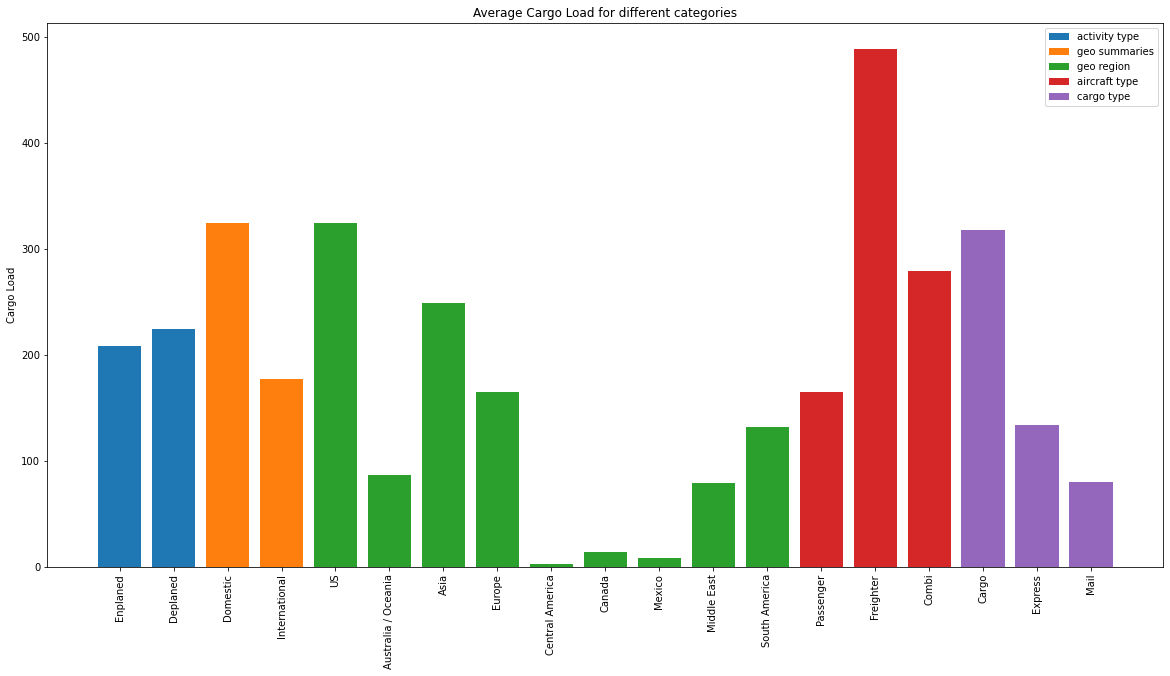

In [10]:
#train.loc[train['Cargo Type Code'] == "Cargo"]
import matplotlib.pyplot as plt

activity_type_mean = get_mean(train, unique_activity_type_code, "Activity Type Code", "Cargo Metric TONS")
geo_summary_mean = get_mean(train, unique_geo_summaries, "GEO Summary", "Cargo Metric TONS")
geo_region_mean = get_mean(train, unique_geo_region, "GEO Region", "Cargo Metric TONS")
unique_aircraft_mean = get_mean(train, unique_aircraft_type, "Cargo Aircraft Type", "Cargo Metric TONS")
cargo_type_mean = get_mean(train, unique_cargo_type_code, "Cargo Type Code", "Cargo Metric TONS")

plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.bar(unique_activity_type_code, activity_type_mean, label="activity type")
plt.bar(unique_geo_summaries, geo_summary_mean, label="geo summaries")
plt.bar(unique_geo_region, geo_region_mean, label="geo region")
plt.bar(unique_aircraft_type, unique_aircraft_mean, label="aircraft type")
plt.bar(unique_cargo_type_code, cargo_type_mean, label="cargo type")

plt.legend()
plt.title("Average Cargo Load for different categories")
plt.ylabel("Cargo Load")
plt.plot()

In [11]:
print_means("Mean By Activity Type", activity_type_mean, unique_activity_type_code, train, "Activity Type Code")
print_means("Mean By Geo Summaries", geo_summary_mean, unique_geo_summaries, train, "GEO Summary")
print_means("Mean By Geo Region", geo_region_mean, unique_geo_region, train, "GEO Region")
print_means("Mean By Aircraft Type", unique_aircraft_mean, unique_aircraft_type, train, "Cargo Aircraft Type")
print_means("Mean By Cargo Type", cargo_type_mean, unique_cargo_type_code, train, "Cargo Type Code")

Mean By Activity Type
Enplaned : 208.50951626861297 [count = 13295]
Deplaned : 224.45560142333662 [count = 13935]

Mean By Geo Summaries
Domestic : 324.20018542978977 [count = 7365]
International : 176.80284213113467 [count = 19865]

Mean By Geo Region
US : 324.20018542978977 [count = 7365]
Australia / Oceania : 86.67114266234348 [count = 1758]
Asia : 248.78508588018198 [count = 10082]
Europe : 164.72853923516877 [count = 4669]
Central America : 2.360648683636364 [count = 385]
Canada : 13.88529708957056 [count = 1467]
Mexico : 8.757863638768526 [count = 877]
Middle East : 78.83348457600003 [count = 550]
South America : 131.6124818181818 [count = 77]

Mean By Aircraft Type
Passenger : 165.17500394883402 [count = 22679]
Freighter : 488.35384855402424 [count = 4224]
Combi : 278.63074549724763 [count = 327]

Mean By Cargo Type
Cargo : 317.2587346456671 [count = 14908]
Express : 133.3231634632665 [count = 3509]
Mail : 79.70028684162051 [count = 8813]



Lets get a count of the different type of aircraft which is being used in US

In [12]:
us_only = train.loc[train["GEO Region"] == "US"]
print(len(us_only))
uni = us_only.groupby('Cargo Aircraft Type').count()
uni

7365


Activity Period  Operating Airline  \
Cargo Aircraft Type                                       
Freighter                       1384               1384   
Passenger                       5981               5981   

                     Operating Airline IATA Code  Published Airline  \
Cargo Aircraft Type                                                   
Freighter                                   1369               1384   
Passenger                                   5981               5981   

                     Published Airline IATA Code  GEO Summary  GEO Region  \
Cargo Aircraft Type                                                         
Freighter                                   1369         1384        1384   
Passenger                                   5981         5981        5981   

                     Activity Type Code  Cargo Type Code  Cargo Metric TONS  
Cargo Aircraft Type                                                          
Freighter                          1384             1384               1384  
Passenger                          5981             5981               5981

#### As seen above, the US has approximately 1/4th of the total number of freighters (1384/4224), so it stands to reason that on average the US has the most Cargo Load out of all the countries

Just to be sure lets get an average of the cargo metric ton available for each type of aircraft in the US 

In [13]:
mean = us_only.groupby('Cargo Aircraft Type').mean()
mean

Activity Period  Cargo Metric TONS
Cargo Aircraft Type                                    
Freighter              201200.648121         851.960138
Passenger              201217.534359         202.076832

We know from the cells above the average cargo metric ton for a freighter is 488.3
As we can see from the cell directly above, the average cargo metric ton for a freighter in the US is 851.9
This is much higher than the average. What this tells us is that the country(geo region) is an important field and we cannot ignore it.

## Preprocessing

Before we start the actual training of the different models, we need to take care of the categorical variables. We use One-Hot-Encoding for that

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
def preprocess(df):
    
    ########## split the date into 3 parts, dd, mm and yy ############################
    N = 2

    # Custom function to split string
    split_string = lambda x: pd.Series([x[i:i+N] for i in range(0, len(x), N)])

    date_split = df['Activity Period'].astype('str').apply(split_string).fillna('')
    date_split.columns = 'var' + (date_split.columns + 1).astype(str).str.zfill(3)
#     print(date_split)
    
    df = pd.concat([df, date_split], axis = 1)
    ########### date split done, and date concatenated with the existing df ##########
    
    # declaring encoder
    ohe = OneHotEncoder(categories='auto')

    # once hot encoding every categorical feature
    feature_arr = ohe.fit_transform(df[['Operating Airline','Operating Airline IATA Code'
                                           ,'Published Airline', 'Published Airline IATA Code'
                                           ,'GEO Summary','GEO Region', 'Activity Type Code'
                                           ,'Cargo Type Code', 'Cargo Aircraft Type', 'var001', 'var002', 'var003']]).toarray()

    # to avoid duplicate col names, gives us the name of every feature which has been encoded
    # duplicates are avoided by appending the col name before the feature
    # ie if df is 
    # col1 col2
    #  a    a
    # feature label will be like col1_a and col2_a
    feature_labels = ohe.get_feature_names_out()
    
    
    # having the feature labels in a dict will let us easily drop features from cols we dont want
    feature_labels_dict = {
        'Operating Airline' : [],
        'Operating Airline IATA Code' : [],
        'Published Airline' : [], 
        'Published Airline IATA Code' : [],
        'GEO Summary' : [],
        'GEO Region' : [],
        'Activity Type Code' : [],
        'Cargo Type Code' : [], 
        'Cargo Aircraft Type' : [],
        'Year' : [],
        'Date' : [],
        'Month' : []
    }

    # filling in the dict
    for label in feature_labels:
        if (label.startswith('Operating Airline_')):
            feature_labels_dict['Operating Airline'].append(label)
        elif label.startswith('Operating Airline IATA Code'):
            feature_labels_dict['Operating Airline IATA Code'].append(label)
        elif label.startswith('Published Airline_'):
            feature_labels_dict['Published Airline'].append(label)
        elif label.startswith('Published Airline IATA Code'):
            feature_labels_dict['Published Airline IATA Code'].append(label)
        elif label.startswith('GEO Summary'):
            feature_labels_dict['GEO Summary'].append(label)
        elif label.startswith('GEO Region'):
            feature_labels_dict['GEO Region'].append(label)
        elif label.startswith('Activity Type Code'):
            feature_labels_dict['Activity Type Code'].append(label)
        elif label.startswith('Cargo Type Code'):
            feature_labels_dict['Cargo Type Code'].append(label)
        elif label.startswith('Cargo Aircraft Type'):
            feature_labels_dict['Cargo Aircraft Type'].append(label)
        elif label.startswith('var001'):
            feature_labels_dict['Year'].append(label)
        elif label.startswith('var002'):
            feature_labels_dict['Date'].append(label)
        elif label.startswith('var003'):
            feature_labels_dict['Month'].append(label)
    
    # flattening the feature labels ie. [[a,b], [c, d, e]] becomes [a,b,c,d,e]
    feature_labels_flattened = np.hstack(feature_labels)
    # creating the new df which just has encoded values for now
    features = pd.DataFrame(feature_arr, columns=feature_labels_flattened)
    # concatenating it with the existing df
    df_new = pd.concat([df, features], axis = 1)
    
    # now that we the encoded values, we can drop the coloumns which we have already encoded
    df_new = df_new.drop(['Operating Airline','Operating Airline IATA Code'
                    ,'Published Airline', 'Published Airline IATA Code'
                    ,'GEO Summary','GEO Region', 'Activity Type Code'
                    ,'Cargo Type Code', 'Cargo Aircraft Type', 'Activity Period'
                    ,'var001', 'var002', 'var003'], axis = 1)
    
    # test data does not have the 'Cargo Metric TONS' field, so our return depends on whether the
    # user wants to preprocess the train or the test data
    return df_new, feature_labels_dict

In [72]:
train_x, train_labels = preprocess(df = train)
train_y = train_x['Cargo Metric TONS']
train_x = train_x.drop("Cargo Metric TONS", axis = 1)

In [74]:
train_y

0          8.871509
1         53.946194
2          0.043999
3         19.023530
4          6.951420
            ...    
27225      5.687690
27226      3.473669
27227     18.564941
27228      9.814090
27229    525.214368
Name: Cargo Metric TONS, Length: 27230, dtype: float64

In [75]:
train_x = train_x.drop(train_labels['Year'], axis = 1)

In [76]:
train_x.iloc[:1]

Operating Airline_ABX Air  Operating Airline_ASTAR USA, LLC  \
0                        0.0                               0.0   

   Operating Airline_ATA Airlines  Operating Airline_Aer Lingus  \
0                             0.0                           0.0   

   Operating Airline_Aeromexico  Operating Airline_Air Berlin  \
0                           0.0                           0.0   

   Operating Airline_Air Canada  Operating Airline_Air Canada Jazz  \
0                           0.0                                0.0   

   Operating Airline_Air Cargo Carriers  Operating Airline_Air China  ...  \
0                                   0.0                          0.0  ...   

   var003_03  var003_04  var003_05  var003_06  var003_07  var003_08  \
0        0.0        0.0        0.0        0.0        0.0        0.0   

   var003_09  var003_10  var003_11  var003_12  
0        0.0        0.0        0.0        0.0  

[1 rows x 397 columns]

In [77]:
test_x, test_labels = preprocess(df = test)

In [78]:
train_y

0          8.871509
1         53.946194
2          0.043999
3         19.023530
4          6.951420
            ...    
27225      5.687690
27226      3.473669
27227     18.564941
27228      9.814090
27229    525.214368
Name: Cargo Metric TONS, Length: 27230, dtype: float64

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [103]:
# scaler = StandardScaler()
# std_y = scaler.fit_transform(train_y.to_frame())

In [104]:
reg = LinearRegression()
reg.fit(train_x, train_y)
np.sqrt(mean_squared_error(train_y, reg.predict(train_x)))

316.3146578388297

In [107]:
ridge = Ridge(alpha=0.02)
ridge.fit(train_x, train_y)
np.sqrt(mean_squared_error(train_y, ridge.predict(train_x)))

315.026403339504

In [93]:
lasso = Lasso(alpha=0.01)
lasso.fit(train_x, train_y)
np.sqrt(mean_squared_error(train_y, lasso.predict(train_x)))

/Users/shubham/miniconda3/envs/cs663/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+08, tolerance: 5.099e+05
  model = cd_fast.enet_coordinate_descent(


315.0523344491106

In [94]:
enet = ElasticNet(random_state=0)
enet.fit(train_x, train_y)
np.sqrt(mean_squared_error(train_y, enet.predict(train_x)))

396.5557263993229

In [95]:
for k, v in train_labels.items():
    print(k)

Operating Airline
Operating Airline IATA Code
Published Airline
Published Airline IATA Code
GEO Summary
GEO Region
Activity Type Code
Cargo Type Code
Cargo Aircraft Type
Year
Date
Month


In [96]:
train_simplest = train_x

In [97]:
train_simplest = train_simplest.drop(train_labels['Operating Airline'], axis = 1)
train_simplest = train_simplest.drop(train_labels['Operating Airline IATA Code'], axis = 1)
train_simplest = train_simplest.drop(train_labels['Published Airline'], axis = 1)
train_simplest = train_simplest.drop(train_labels['Published Airline IATA Code'], axis = 1)
# train_simplest = train_simplest.drop(train_labels['GEO Region'], axis = 1)
# train_simplest = train_simplest.drop(train_labels['GEO Summary'], axis = 1)
train_simplest = train_simplest.drop(train_labels['Date'], axis = 1)
train_simplest = train_simplest.drop(train_labels['Month'], axis = 1)

In [98]:
train_simplest

GEO Summary_Domestic  GEO Summary_International  GEO Region_Asia  \
0                       1.0                        0.0              0.0   
1                       1.0                        0.0              0.0   
2                       0.0                        1.0              0.0   
3                       0.0                        1.0              1.0   
4                       0.0                        1.0              1.0   
...                     ...                        ...              ...   
27225                   0.0                        1.0              0.0   
27226                   0.0                        1.0              1.0   
27227                   1.0                        0.0              0.0   
27228                   0.0                        1.0              0.0   
27229                   0.0                        1.0              1.0   

       GEO Region_Australia / Oceania  GEO Region_Canada  \
0                                 0.0                0.0   
1                                 0.0                0.0   
2                                 1.0                0.0   
3                                 0.0                0.0   
4                                 0.0                0.0   
...                               ...                ...   
27225                             0.0                1.0   
27226                             0.0                0.0   
27227                             0.0                0.0   
27228                             0.0                1.0   
27229                             0.0                0.0   

       GEO Region_Central America  GEO Region_Europe  GEO Region_Mexico  \
0                             0.0                0.0                0.0   
1                             0.0                0.0                0.0   
2                             0.0                0.0                0.0   
3                             0.0                0.0                0.0   
4                             0.0                0.0                0.0   
...                           ...                ...                ...   
27225                         0.0                0.0                0.0   
27226                         0.0                0.0                0.0   
27227                         0.0                0.0                0.0   
27228                         0.0                0.0                0.0   
27229                         0.0                0.0                0.0   

       GEO Region_Middle East  GEO Region_South America  GEO Region_US  \
0                         0.0                       0.0            1.0   
1                         0.0                       0.0            1.0   
2                         0.0                       0.0            0.0   
3                         0.0                       0.0            0.0   
4                         0.0                       0.0            0.0   
...                       ...                       ...            ...   
27225                     0.0                       0.0            0.0   
27226                     0.0                       0.0            0.0   
27227                     0.0                       0.0            1.0   
27228                     0.0                       0.0            0.0   
27229                     0.0                       0.0            0.0   

       Activity Type Code_Deplaned  Activity Type Code_Enplaned  \
0                              0.0                          1.0   
1                              1.0                          0.0   
2                              1.0                          0.0   
3                              1.0                          0.0   
4                              1.0                          0.0   
...                            ...                          ...   
27225                          0.0                          1.0   
27226                          1.0                         

In [99]:
reg.fit(train_simplest, train_y)
ridge.fit(train_simplest, train_y)
lasso.fit(train_simplest, train_y)
enet.fit(train_simplest, train_y)

/Users/shubham/miniconda3/envs/cs663/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+08, tolerance: 5.099e+05
  model = cd_fast.enet_coordinate_descent(


ElasticNet(random_state=0)

In [101]:
y_2 = reg.predict(train_simplest)
mse = mean_squared_error(train_y, y_2)
print(np.sqrt(mse))

y_2 = ridge.predict(train_simplest)
mse = mean_squared_error(train_y, y_2)
print(np.sqrt(mse))

y_2 = lasso.predict(train_simplest)
mse = mean_squared_error(train_y, y_2)
print(np.sqrt(mse))

y_2 = enet.predict(train_simplest)
mse = mean_squared_error(train_y, y_2)
print(np.sqrt(mse))

y_2

398.4209741815606
398.41540941329646
398.41548533179594
410.35003655001805


array([288.68187024, 296.92881118, 144.82831787, ..., 296.92881118,
       206.75119845, 239.46070175])

In [36]:
# train_y
# test_y = train_simplest.iloc[:1]
# print(test_y)
# print(ridge.predict(train_simplest.iloc[:1]))

In [37]:
poly = PolynomialFeatures(4)
output_nparray = poly.fit_transform(train_simplest)
output_nparray.shape

(27230, 8855)

In [ ]:
reg.fit(output_nparray, train_y)
y_2 = reg.predict(output_nparray)
mse = mean_squared_error(train_y, y_2)
mse